In [265]:
import numpy as np
from sys import argv
import matplotlib.pyplot as plt
import random

%matplotlib inline 
plt.rcParams["figure.figsize"] = [9, 6]

In [267]:
L = 40  # parameter to set granularity
ip_file = "625_ai/Project 1/Code/heatmap_2.txt"
X_MAX, Y_MAX = [0, 0]

In [268]:
pdist_list = []
last_line = ''

with open(ip_file, 'r') as heatmap:
        for line in heatmap:
            points = line.split()
            pdist_list.append(points[2])
        last_line = line
        
X_MAX = int(last_line.split()[0])
Y_MAX = int(last_line.split()[1])

In [269]:
pdist = np.reshape(np.array(pdist_list, dtype=float), [X_MAX+1, Y_MAX+1])

C = np.max(pdist)/L

gw_pdist = [] # list of matrices
for i in range(0, L):
    interim_gw = pdist - (C*i)
    interim_gw = interim_gw.clip(min=0)
    gw_pdist.append(interim_gw)
    
global_efficiency = []

for distr in gw_pdist:
    temp = distr.flatten()
    temp[::-1].sort()
    global_efficiency.append(temp)   

In [270]:
def get_neighbours(coord):
    x = [x for x in [coord[0]-1, coord[0], coord[0]+1] if x >=0 and x <= X_MAX]
    y = [y for y in [coord[1]-1, coord[1], coord[1]+1] if y >=0 and y <= Y_MAX]
    
    neighbours = []
    for i in x:
        for j in y:
            if [i, j] != coord:
                neighbours.append([i, j])
                
    return neighbours
    

In [271]:
def get_least_euclidean_dist_loc(start, end_list):
    dist = np.linalg.norm(end_list - start, axis=1)
    best_location = dist.argmin()
    return end_list[best_location]

In [272]:
d = np.linalg.norm(np.array([0, 0]) - np.array([2, 2]))
print d

2.82842712475


In [273]:
# cumulative probabilities of all paths;
# each element represents a path whose indices represent the accumulated probability at each step
global_cp = []
global_paths = []
global_efficiency_lb_d = 0
closest_non_zero_found = False 

for i in range(len(gw_pdist)):
    
    T = 0
    robo_loc = [0, 0]

    # accumluate the probabllity covered of starting cell
    cp = [pdist[robo_loc[0], robo_loc[1]]]

    # set the pseudo-probability of starting cell to zero
    (gw_pdist[i])[robo_loc[0]][robo_loc[1]] = 0

    pseudo_pdist = gw_pdist[i]
    point_list = []
    point_list.append(robo_loc)

    while pseudo_pdist.any():
        
        if not closest_non_zero_found:
            if pdist[robo_loc[0], robo_loc[1]] > 0:
                d = np.linalg.norm(np.array([0, 0]) - np.array(robo_loc))
                global_efficiency_lb_d = int(d)
                closest_non_zero_found = True

        #print "At T = ", T, " \t Current node is:", robo_loc

        neighbours = get_neighbours(robo_loc)
        #print "Neighbours being considered: ", neighbours

        max_prob = 0
        for neighbour in neighbours:
            if pseudo_pdist[neighbour[0], neighbour[1]] >= max_prob:
                max_prob = pseudo_pdist[neighbour[0], neighbour[1]]

        best_neighbours = []
        for neighbour in neighbours:
            if pseudo_pdist[neighbour[0], neighbour[1]] == max_prob:
                best_neighbours.append(neighbour)

        #print "Best neighbours: ", best_neighbours

        best_neighbour = None
        # no tie-breaker required
        if len(best_neighbours) == 1:
            # print "Best neighbour is: ", best_neighbours[0]
            # set new robot location
            robo_loc = best_neighbours[0]
            best_neighbour = best_neighbours[0]

        else:                                                               # tie-breaker required

            # get next highest probability node(s)
            hpn_locs = np.argwhere(pseudo_pdist == np.max(pseudo_pdist))
            #print len(hpn_locs), "possible locations being considered."
            best_hpn_loc = get_least_euclidean_dist_loc(np.array(robo_loc),  # get coord of HPN with least distance from
                                                            hpn_locs)        # current node
            #print "Nearest HPN location:", best_hpn_loc

            best_neighbour = get_least_euclidean_dist_loc(                  # get coord of neighbour with least distance
                    best_hpn_loc, np.array(best_neighbours))                # from thr nearest HPN
            #print "Best beighbour is:", best_neighbour.tolist()

            # set new robot location
            robo_loc = best_neighbour.tolist()
            best_neighbour = best_neighbour.tolist()
            
        # get probability accumulated till last step
        last_step_cp = cp[-1]
        current_prob = 0
        if best_neighbour in point_list:
            current_prob = 0
        else:
            current_prob = pdist[best_neighbour[0], best_neighbour[1]]
        cp.append(last_step_cp + current_prob)                            # add new probability
        # append new location to node list
        point_list.append(robo_loc)
        # set visited node's pseudo prob value to zero
        pseudo_pdist[best_neighbour[0], best_neighbour[1]] = 0            
        T += 1
        #print "-"*60

    global_cp.append(cp)
    global_paths.append(point_list)

In [274]:
path_efficiency = []
path_efficiency_lb = []
for i in [100, 200, 300, 600, 900]:
    print "At T =",i,"\n","-"*60
    efficiency = (global_cp[9])[i-1]/np.sum((global_efficiency[0])[:(i-1-global_efficiency_lb_d)])*100
    efficiency_lb = (global_cp[9])[i-1]/np.sum((global_efficiency[0])[:(i-1)])*100
    print "Effieciency:",efficiency,"\tEfficiency LB:", efficiency_lb
    print "-"*60

At T = 100 
------------------------------------------------------------
Effieciency: 98.2638888889 	Efficiency LB: 63.5241301908
------------------------------------------------------------
At T = 200 
------------------------------------------------------------
Effieciency: 99.3224932249 	Efficiency LB: 81.8537130095
------------------------------------------------------------
At T = 300 
------------------------------------------------------------
Effieciency: 99.5791245791 	Efficiency LB: 87.922705314
------------------------------------------------------------
At T = 600 
------------------------------------------------------------
Effieciency: 95.3112687155 	Efficiency LB: 89.742162864
------------------------------------------------------------
At T = 900 
------------------------------------------------------------
Effieciency: 96.8235596708 	Efficiency LB: 93.0540106291
------------------------------------------------------------


In [275]:
for i in range(0, len(global_cp)):
    print i, "\t---->\t", (global_cp[i])[899] 

0 	---->	0.414489646223
1 	---->	0.414489646223
2 	---->	0.414489646223
3 	---->	0.414489646223
4 	---->	0.414489646223
5 	---->	0.414489646223
6 	---->	0.414489646223
7 	---->	0.414489646223
8 	---->	0.414489646223
9 	---->	0.424815211872
10 	---->	0.424815211872
11 	---->	0.424815211872
12 	---->	0.424815211872
13 	---->	0.424815211872
14 	---->	0.424815211872
15 	---->	0.424815211872
16 	---->	0.424815211872
17 	---->	0.424815211872
18 	---->	0.424815211872
19 	---->	0.424815211872
20 	---->	0.424815211872
21 	---->	0.424815211872
22 	---->	0.424815211872
23 	---->	0.424815211872
24 	---->	0.424815211872
25 	---->	0.424815211872
26 	---->	0.424815211872
27 	---->	0.436156406929
28 	---->	0.436156406929
29 	---->	0.436156406929
30 	---->	0.436156406929
31 	---->	0.436156406929
32 	---->	0.436156406929
33 	---->	0.436156406929
34 	---->	0.436156406929
35 	---->	0.436156406929
36 	---->	0.436156406929
37 	---->	0.436156406929
38 	---->	0.436156406929
39 	---->	0.436156406929


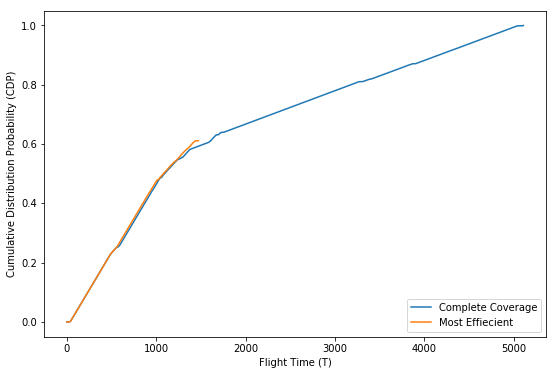

In [276]:
plt.plot(range(len(global_cp[0])), global_cp[0], label='Complete Coverage')
plt.plot(range(len(global_cp[9])), global_cp[9], label='Most Effiecient')
plt.xlabel('Flight Time (T)')
plt.ylabel('Cumulative Distribution Probability (CDP)')
plt.legend(loc='lower right')
plt.show()

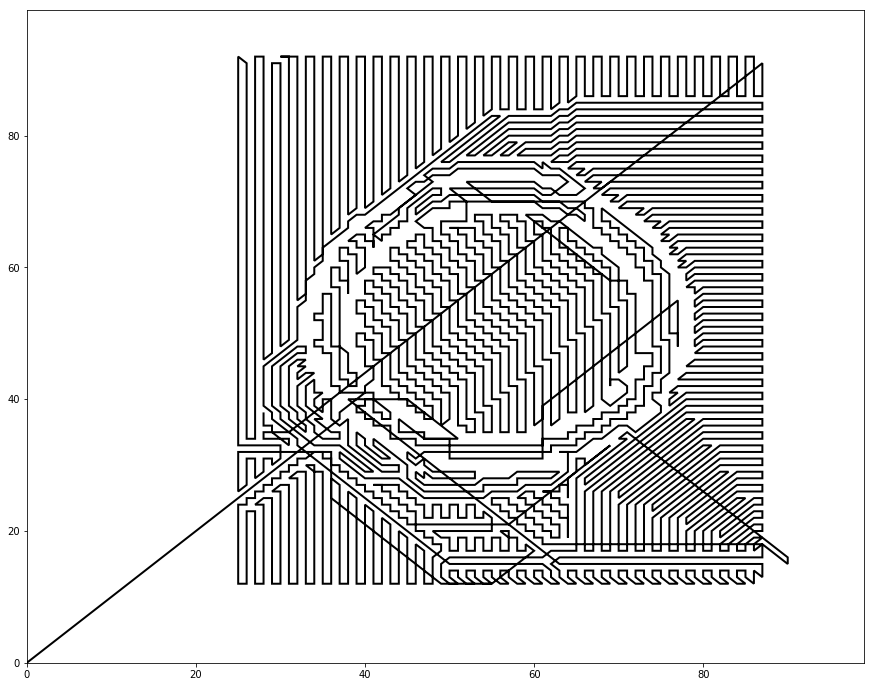

In [181]:
from matplotlib.path import Path
import matplotlib.patches as patches

verts = global_paths[0]

codes = [Path.MOVETO]
for i in range(len(verts)-1):
    codes.append(Path.LINETO)

path = Path(verts, codes)

fig = plt.figure()
ax = fig.add_subplot(111)
patch = patches.PathPatch(path, facecolor='none', lw=2)
ax.add_patch(patch)
ax.set_xlim(0, X_MAX)
ax.set_ylim(0, Y_MAX)
plt.show()

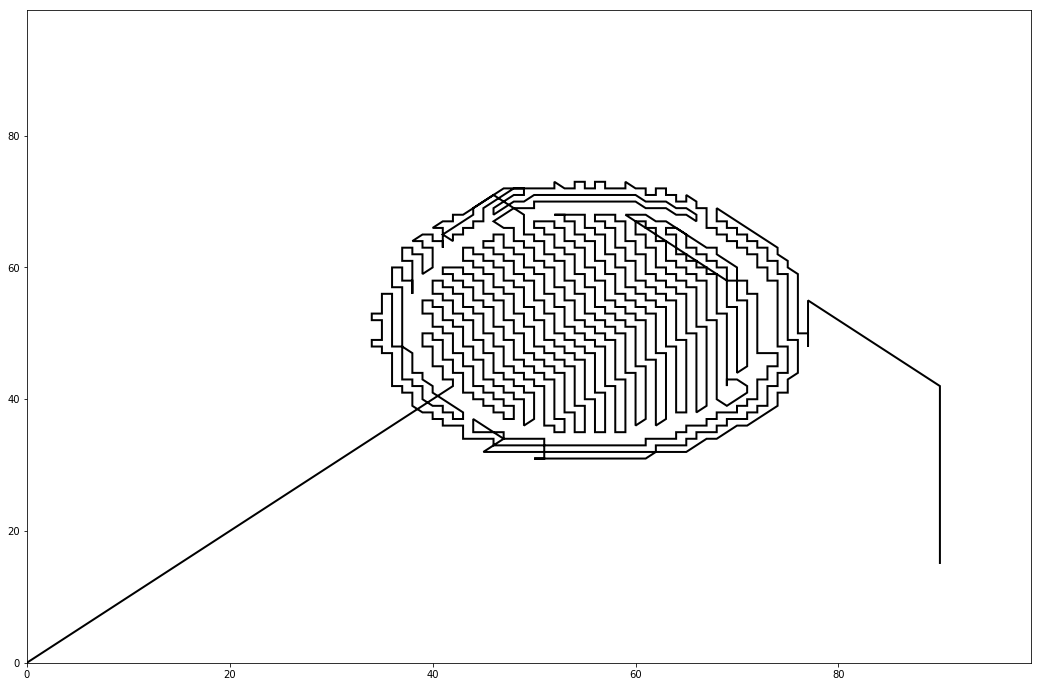

In [97]:
verts = global_paths[0]

codes = [Path.MOVETO]
for i in range(len(verts)-1):
    codes.append(Path.LINETO)

path = Path(verts, codes)

fig = plt.figure()
ax = fig.add_subplot(111)
patch = patches.PathPatch(path, facecolor='none', lw=2)
ax.add_patch(patch)
ax.set_xlim(0, X_MAX)
ax.set_ylim(0, Y_MAX)
plt.show()

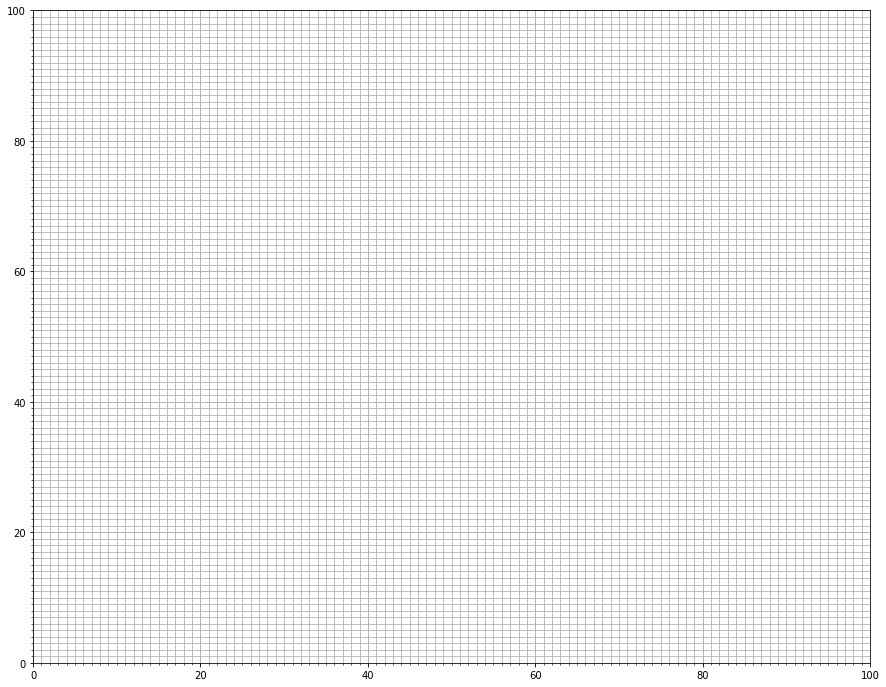

In [205]:
import matplotlib.animation as animation
from IPython.display import HTML
import time

fig = plt.figure()
ax = plt.axes(xlim=(0, X_MAX+1), ylim=(0, Y_MAX+1))
ax.minorticks_on()
minor_ticks = np.arange(0, X_MAX+1, 1)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(True, which='both', axis='both')

T = 0
x = []
y = []

line, = ax.plot(x, y, lw=2)  
#plt.title('T = ' + str(i) + '   Cum. Probability = ' + "{0:.2f}".format((global_cp[0])[0]*100) + '%', fontsize=20)

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    x.append((global_paths[0])[i][0])
    y.append((global_paths[0])[i][1])
    line.set_data(x, y)
    fig.suptitle('T = '+str(i)+'    Cum. Probability = '+  "{0:.2f}".format((global_cp[0])[i]*100) +'%', fontsize=20)
    i+=1
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=10, interval=10, blit=True)

#HTML(anim.to_html5_video())

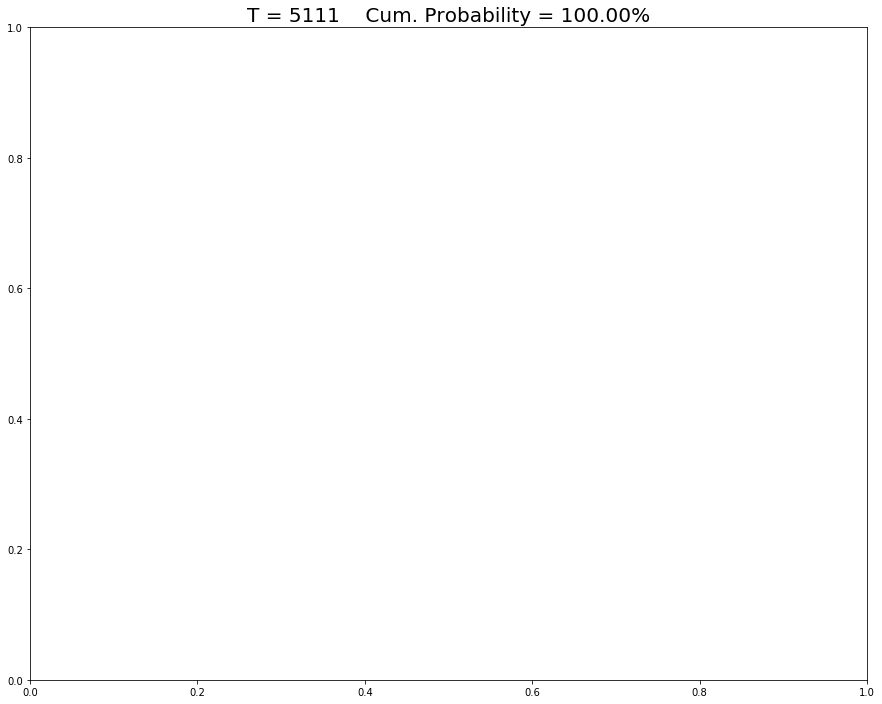

In [202]:

Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Ankur Roy Chowdhury'), bitrate=1800)

anim.save('heatmap2_path_0.mp4', writer=writer)